In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score
)
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

def mps_ok():
    return hasattr(torch.backends, "mps") and torch.backends.mps.is_built() and torch.backends.mps.is_available()

def auto_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    if mps_ok():
        return torch.device("mps")
    return torch.device("cpu")

device = auto_device()
print("Using device:", device)


Using device: mps


# Load Preprocessed Data

In [2]:
POSSIBLE_DIRS = [
    "from_kaggle/cleaned_data",
    "/kaggle/working",
    "/kaggle/input",
]

def find_clean_paths():
    for d in POSSIBLE_DIRS:
        train_candidate = os.path.join(d, "train_clean.csv")
        test_candidate = os.path.join(d, "test_clean.csv")
        if os.path.exists(train_candidate) and os.path.exists(test_candidate):
            return train_candidate, test_candidate
    raise FileNotFoundError("Could not find train_clean.csv and test_clean.csv in known locations.")

train_clean_path, test_clean_path = find_clean_paths()
print("Train clean path:", train_clean_path)
print("Test clean  path:", test_clean_path)

train_df = pd.read_csv(train_clean_path)
test_df = pd.read_csv(test_clean_path)

print("Train_clean shape:", train_df.shape)
print("Test_clean shape :", test_df.shape)
train_df.head()


Train clean path: from_kaggle/cleaned_data/train_clean.csv
Test clean  path: from_kaggle/cleaned_data/test_clean.csv
Train_clean shape: (8693, 50041)
Test_clean shape : (4277, 50040)


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerNumber,CabinNum,TotalSpend,...,Surname_Wooterston,Surname_Workmans,Surname_Workmanson,Surname_Wrempeedly,Surname_Wriggins,Surname_Wynneyerson,Surname_Yanton,Surname_Yatters,Surname_Yorkland,Surname_Youngrayes
0,0.720932,-0.340290,-0.281822,-0.292365,-0.269707,-0.257100,0.0,-0.490655,-1.181321,-0.510541,...,0,0,0,0,0,0,0,0,0,0
1,-0.332557,-0.170439,-0.276082,-0.249566,0.221040,-0.219449,1.0,-0.490655,-1.181321,-0.248363,...,0,0,0,0,0,0,0,0,0,0
2,2.055350,-0.273285,1.998823,-0.292365,5.732776,-0.215170,0.0,-0.490655,-1.181321,3.188082,...,0,0,0,0,0,0,0,0,0,0
3,0.299536,-0.340290,0.536429,0.342766,2.706059,-0.091947,0.0,0.468615,-1.181321,1.333249,...,0,0,0,0,0,0,0,0,0,0
4,-0.894417,0.131863,-0.237179,-0.033861,0.235342,-0.255389,1.0,-0.490655,-1.179351,-0.121906,...,0,0,0,0,0,0,0,0,0,0


# Prepare Features and Target

In [3]:
target_col = "Transported"

if train_df[target_col].dtype == bool:
    train_df[target_col] = train_df[target_col].astype(int)
elif train_df[target_col].dtype == object:
    mapping = {"True": 1, "False": 0, "true": 1, "false": 0}
    train_df[target_col] = train_df[target_col].map(mapping).astype(int)
else:
    train_df[target_col] = train_df[target_col].astype(int)

feature_cols = [c for c in train_df.columns if c != target_col]
print("Number of features:", len(feature_cols))

X = train_df[feature_cols].values.astype(np.float32)
y = train_df[target_col].values.astype(np.float32)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_val.shape


Number of features: 50040


((6954, 50040), (1739, 50040))

# Dataset and DataLoaders

In [4]:
class TitanicDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.from_numpy(X).float()
        self.y = None if y is None else torch.from_numpy(y).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.y is None:
            return x
        return x, self.y[idx]

batch_size = 256

train_ds = TitanicDataset(X_train, y_train)
val_ds   = TitanicDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)


# Regularized MLP

In [56]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=(64, 32), dropout=0.3):
        super().__init__()
        layers = []
        dims = [input_dim] + list(hidden_dims)

        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(nn.BatchNorm1d(dims[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))

        self.feature_extractor = nn.Sequential(*layers)
        self.classifier = nn.Linear(dims[-1], 1)

    def forward_features(self, x):
        return self.feature_extractor(x)

    def forward(self, x):
        feats = self.forward_features(x)
        logits = self.classifier(feats)
        return logits, feats

input_dim = X_train.shape[1]
model = SimpleMLP(input_dim=input_dim, hidden_dims=(32,16), dropout=0.6).to(device)
model


SimpleMLP(
  (feature_extractor): Sequential(
    (0): Linear(in_features=50040, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.6, inplace=False)
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.6, inplace=False)
  )
  (classifier): Linear(in_features=16, out_features=1, bias=True)
)

# Training and Evaluation Utilities


In [57]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    n_samples = 0

    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).view(-1, 1)

        optimizer.zero_grad()
        logits, _ = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        batch_size = X_batch.size(0)
        running_loss += loss.item() * batch_size
        n_samples += batch_size

    return running_loss / max(n_samples, 1)


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    n_samples = 0
    all_logits = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).view(-1, 1)

            logits, _ = model(X_batch)
            loss = criterion(logits, y_batch)

            batch_size = X_batch.size(0)
            running_loss += loss.item() * batch_size
            n_samples += batch_size

            all_logits.append(logits.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())

    avg_loss = running_loss / max(n_samples, 1)
    all_logits = np.vstack(all_logits).reshape(-1)
    all_targets = np.vstack(all_targets).reshape(-1)

    return avg_loss, all_logits, all_targets


# Train the Model with Early Stopping

In [58]:
lr = 1e-3
n_epochs = 60
patience = 8
min_delta = 1e-4

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3, verbose=True
)

train_losses = []
val_losses = []

best_val_loss = float("inf")
best_state_dict = None
epochs_no_improve = 0

for epoch in range(1, n_epochs + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_logits, val_targets = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    if val_loss + min_delta < best_val_loss:
        best_val_loss = val_loss
        best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epoch % 5 == 0 or epoch == 1:
        print(
            f"Epoch {epoch:02d}/{n_epochs} | Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f} | No improve: {epochs_no_improve}"
        )

    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch} (best val loss {best_val_loss:.4f})")
        break

# restore best weights
if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
    model.to(device)


Epoch 01/60 | Train Loss: 0.6280 | Val Loss: 0.6595 | No improve: 0
Epoch 05/60 | Train Loss: 0.4041 | Val Loss: 0.4573 | No improve: 0
Epoch 10/60 | Train Loss: 0.2423 | Val Loss: 0.4373 | No improve: 3
Epoch 15/60 | Train Loss: 0.1886 | Val Loss: 0.4585 | No improve: 8
Early stopping at epoch 15 (best val loss 0.4374)


# Loss Curves

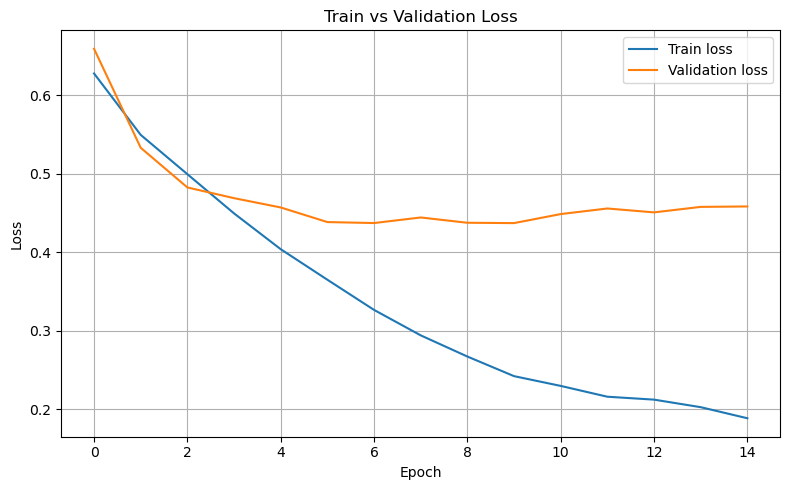

In [59]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Confusion Matrix, ROC, and Threshold Tuning

Best validation accuracy 0.7941 at threshold 0.60
Confusion matrix:
 [[717 146]
 [212 664]]

Classification report:
               precision    recall  f1-score   support

         0.0     0.7718    0.8308    0.8002       863
         1.0     0.8198    0.7580    0.7877       876

    accuracy                         0.7941      1739
   macro avg     0.7958    0.7944    0.7939      1739
weighted avg     0.7960    0.7941    0.7939      1739



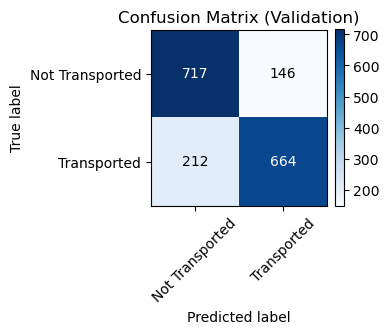

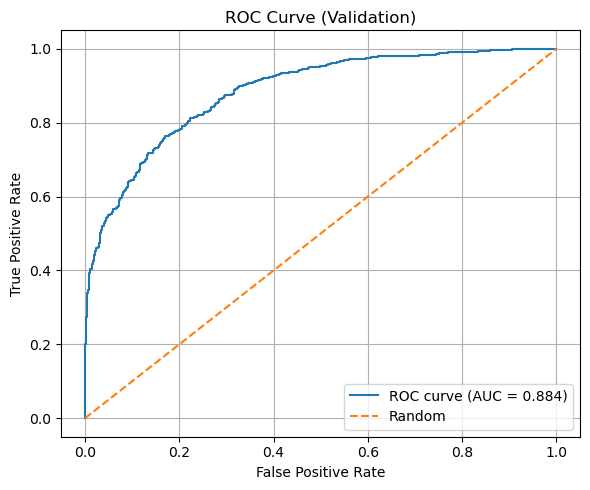

In [60]:
# evaluate with best model
val_loss, val_logits, val_targets = evaluate(model, val_loader, criterion, device)
val_probs = 1 / (1 + np.exp(-val_logits))  # sigmoid

# threshold tuning on validation set
thresholds = np.linspace(0.1, 0.9, 17)
best_thr = 0.5
best_acc = 0.0

for thr in thresholds:
    preds_thr = (val_probs >= thr).astype(int)
    acc_thr = (preds_thr == val_targets).mean()
    if acc_thr > best_acc:
        best_acc = acc_thr
        best_thr = thr

print(f"Best validation accuracy {best_acc:.4f} at threshold {best_thr:.2f}")

val_preds = (val_probs >= best_thr).astype(int)

cm = confusion_matrix(val_targets, val_preds)
print("Confusion matrix:\n", cm)
print("\nClassification report:\n", classification_report(val_targets, val_preds, digits=4))

# plot confusion matrix
plt.figure(figsize=(4, 4))
im = plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.title("Confusion Matrix (Validation)")
plt.colorbar(im, fraction=0.046, pad=0.04)
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Not Transported", "Transported"], rotation=45)
plt.yticks(tick_marks, ["Not Transported", "Transported"])

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], "d"),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(val_targets, val_probs)
auc = roc_auc_score(val_targets, val_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Final-Layer Embeddings Visualization

Embeddings shape: (8693, 16)


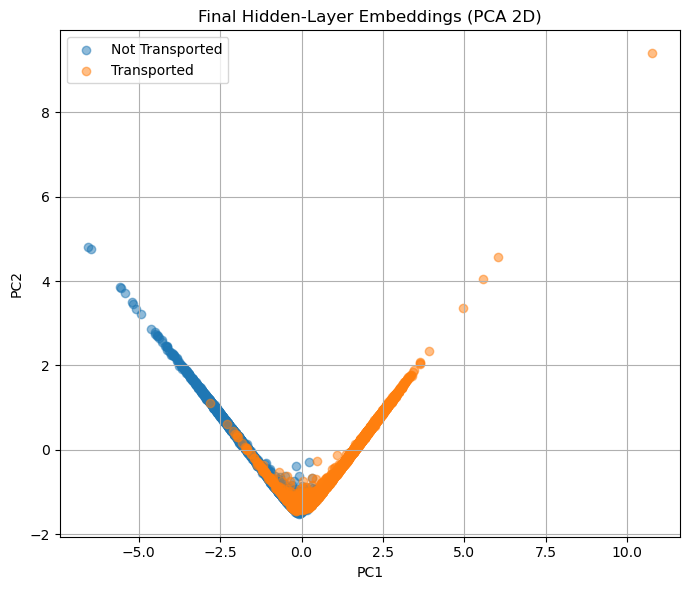

In [61]:

# full training embeddings
full_train_ds = TitanicDataset(X, y)
full_train_loader = DataLoader(full_train_ds, batch_size=512, shuffle=False)

model.eval()
all_embs = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in full_train_loader:
        X_batch = X_batch.to(device)
        _, feats = model(X_batch)
        all_embs.append(feats.cpu().numpy())
        all_labels.append(y_batch.numpy())

all_embs = np.vstack(all_embs)
all_labels = np.concatenate(all_labels)

print("Embeddings shape:", all_embs.shape)

# PCA to 2D
pca = PCA(n_components=2, random_state=42)
embs_2d = pca.fit_transform(all_embs)

plt.figure(figsize=(7, 6))
mask_transported = all_labels == 1
plt.scatter(embs_2d[~mask_transported, 0], embs_2d[~mask_transported, 1],
            alpha=0.5, label="Not Transported")
plt.scatter(embs_2d[mask_transported, 0], embs_2d[mask_transported, 1],
            alpha=0.5, label="Transported")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Final Hidden-Layer Embeddings (PCA 2D)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
